In [3]:
import numpy as np
from matplotlib import pyplot as plt
from os import listdir
import json

In [2]:
def get_y_val(x, xs, ys):
    for i in range(xs.shape[0]):
        if xs[i] > x:
            # This is upper bound, previous is lower bound
            if i == 0:
                end, start = xs[i], 0
                l = (x-start)/(end-start)
                return ys[i]#(l)*ys[i]
            end, start = xs[i], xs[i-1]
            l = (x-start)/(end-start)
            return (l)*ys[i] + (1-l)*ys[i-1]
    return ys[len(ys)-1]

def get_average_plot(data):
    end_time = 0
    for d in data:
        end_time = max(end_time, np.max(d[0]))
    xs = np.array(range(0, int(end_time)))
    yss = np.array([[get_y_val(x, d[0], d[1]) for x in xs] for d in data])
    ys_agv = np.sum(yss, axis=0) / yss.shape[0]
    ys_std = np.std(yss, axis=0)
    return xs, ys_agv, ys_std

def average_plot(data, color=(0.02745098, 0.50588235, 0.87058824), plot_std=True):
    xs, ys_avg, ys_std = get_average_plot(data)
    if plot_std:
        plt.fill_between(xs, ys_avg-ys_std, ys_avg+ys_std, color=(color[0], color[1], color[2], 0.25))
    plt.plot(xs, ys_avg, color=color)


In [11]:
def read_database(path="./data"):
    db = []
    for filename in listdir(path):
        with open(path+"/"+filename, "r") as f:
            db.append(json.loads(f.read()))
    return db

def find_all_data(db, exid, node_count, sync_rate):
    data = []
    for d in db:
        if d['exid'] == exid and d['node_count'] == node_count and d['sync_rate'] == sync_rate:
            data.extend([np.array(x) for x in d['nodes_data']])
    return data

In [28]:
def setup_accuracy_graph():
    plt.xticks([x for x in range(0, 21, 1)])
    plt.yticks([x for x in range(0, 110, 10)])
    plt.ylim(0, 100)
    plt.xlim(0, 20)
    plt.grid()

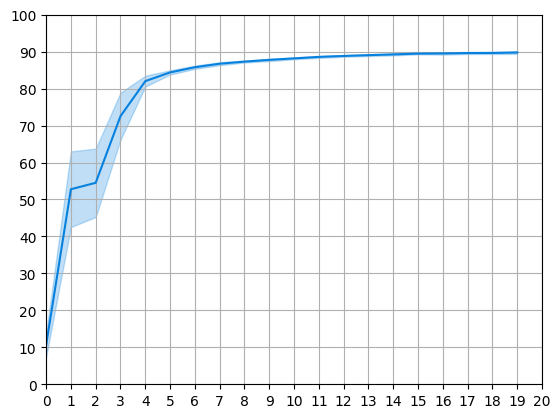

In [30]:
db = read_database()
average_plot(find_all_data(db, "swarm_ic", 10, 0.6))
setup_accuracy_graph()
plt.show()